<a href="https://colab.research.google.com/github/Yarida-nes/weatherwise-Yarida-Kaewthong/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [11]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install hands-on-ai
!pip install PyInputPlus
!pip install requests
!pip install matplotlib

In [87]:

import os

os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'

## 📦 Setup and Configuration
Import required packages and setup environment.

In [12]:
import requests
import matplotlib.pyplot as plt
# Install pyinputplus if not already installed
!pip install pyinputplus
import pyinputplus as pyip
# ✅ Import after installing (if needed)
from fetch_my_weather import get_weather
from hands_on_ai.chat import get_response

# Add any other setup code here

In [88]:
# libraries
import os
import re
from typing import Dict, Any, List, Optional, Tuple, Union
import requests
import matplotlib.pyplot as plt

os.environ["OPENWEATHER_API_KEY"] = "220e281f356576ed04365173258a3eb1"  # Demo key, get your own at https://openweathermap.org/api
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# pyinputplus is preferred for menus, but guard if missing in some environments
try:
	import pyinputplus as pyip
except Exception:
	pyip = None  # UI cell will handle None gracefully

# Fetch weather via the teaching helper library
try:
	import fetch_my_weather as fmw
except Exception as e:
	fmw = None
	print("Warning: fetch_my_weather not installed. You can install it in Colab by running the optional pip cell above.")

# Global state used by UI/demo (kept minimal)
_LAST_LOCATION: Optional[str] = None
_LAST_FORECAST_DAYS: int = 5
_LAST_WEATHER: Optional[Dict[str, Any]] = None

# Helper for safe matplotlib usage in notebooks
plt.rcParams.update({
	"figure.figsize": (8, 4),
	"axes.grid": True ,
 })


## 🌤️ Weather Data Functions

In [89]:
# Define get_weather_data() function here
from typing import TypedDict

class ParsedWeather(TypedDict, total=False):
	location: str
	forecast_days: int
	error: Optional[str]
	current: Dict[str, Any]
	daily: List[Dict[str, Any]]


def _normalize_fmw_json(model_or_dict: Any) -> Dict[str, Any]:
	"""
	Convert fetch_my_weather WeatherResponse (Pydantic) or raw dict to a plain dict.
	This keeps only the keys we care about for the assignment to simplify downstream code.
	"""
	# If it's a pydantic model, use model_dump if available
	if hasattr(model_or_dict, "model_dump"):
		data = model_or_dict.model_dump()  # type: ignore[attr-defined]
	else:
		data = dict(model_or_dict)
	return data

def openWeather_getWeather(city: str, units: str = "metric"):
	api_key = os.getenv("OPENWEATHER_API_KEY")
	if not api_key:
		return None
	try:
		CITY = city
		UNITS = units  # metric for °C or "imperial" for °F
		# Step 1: Call the 5-day forecast API
		url = f"https://api.openweathermap.org/data/2.5/forecast?q={CITY}&appid={api_key}&units={UNITS}"
		response = requests.get(url)
		data = response.json()
		return data
	except Exception as e:
		print(f"Error fetching weather data: {e}")
		return None





def get_weather_data(city: str, forecast_days: int = 5):
	"""
	Retrieve weather data for a specified location.

	Args:
		location (str): City or location name
		forecast_days (int): Number of days to forecast (1-5)

	Returns:
		dict: Weather data including current conditions and forecast
	"""
	response: ParsedWeather = {"location": city, "forecast_days": forecast_days}
	try:
		response = openWeather_getWeather(city=city, units="metric")
		return response
	except Exception as e:
		response["error"] = f"Failed to fetch weather data: {e}"
		return response

## 📊 Visualisation Functions

In [126]:
# Define create_temperature_visualisation() and create_precipitation_visualisation() here
from datetime import datetime
from typing import List, Dict, Any

def _extract_day_labels(daily: List[Dict[str, Any]]) -> List[str]:
        labels: List[str] = []
        for d in daily:
                date_str = d.get("date") or d.get("astronomy", [{}])[0].get("sunrise")
                try:
                        labels.append(datetime.strptime(date_str, "%Y-%m-%d").strftime("%a %d"))
                except Exception:
                        labels.append(str(date_str))
        return labels

def get_temps(data):
        daily_temps = {}

        for item in data["list"]:
                dt_txt = item["dt_txt"] # e.g., '2025-10-16 03:00:00'
                date_str = dt_txt.split(" ")[0] # Just the date part
                temp = item["main"]["temp"]

                if date_str not in daily_temps:
                        daily_temps[date_str] = []

                daily_temps[date_str].append(temp)

        return daily_temps


def create_temperature_visualisation(weather_data: Dict[str, Any], num_days: int = 5, output_type: str = 'display'):
        """
        Create visualisation of temperature data using average daily temperatures.

        Args:
                weather_data (dict): The processed weather data
                num_days (int): The number of days to display in the chart.
                output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

        Returns:
                If output_type is 'figure', returns the matplotlib figure object
                Otherwise, displays the visualisation in the notebook
        """

        # get daily forecast data
        daily = weather_data.get("list", [])
        if not daily:
                print("No daily forecast data available to plot temperatures.")
                return None

        daily_temps = get_temps(weather_data)
        # Slice the data to include only the requested number of days
        sliced_dates = list(daily_temps.keys())[:num_days]
        sliced_temps = [sum(daily_temps[date]) / len(daily_temps[date]) if daily_temps[date] else 0 for date in sliced_dates]


        fig, ax = plt.subplots()
        ax.plot(sliced_dates, sliced_temps, marker='o', label='Average Temp (°C)')
        ax.set_title(f"Daily Average Temperature Forecast for {num_days} Days")
        ax.set_xlabel("Day")
        ax.set_ylabel("Temperature (°C)")
        ax.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()

        if output_type == 'figure':
                return fig
        else:
                plt.show()
                return None

In [21]:
# @title
# Define create_temperature_visualisation() here
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of temperature data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    forecast = weather_data.get("forecast", [])
    if not forecast:
        print("⚠️ No forecast data available to plot.")
        return

    location = weather_data.get("location", "Unknown")

    fig, ax = plt.subplots(figsize=(10, 6))


    for day in forecast:
        date = day["date"]
        hours = [int(h.get("time", "0")) // 100 for h in day.get("hourly", [])]  # "600" -> 6
        temps = [int(h.get("tempC", 0)) for h in day.get("hourly", [])]

        ax.plot(
            hours, temps,
            marker="o",
            linewidth=2,
            label=f"{date}",
            alpha=0.9
        )


        for x, y in zip(hours, temps):
            ax.text(x, y + 0.5, f"{y}°C", ha="center", va="bottom", fontsize=8, color="red")


    ax.set_title(f"Temperature Forecast – {weather_data.get('location', 'Unknown')}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Hour of Day", fontsize=12)
    ax.set_ylabel("Temperature (°C)", fontsize=12)
    ax.set_xticks(range(0, 25, 3))
    ax.grid(axis="both", linestyle="--", alpha=0.6)
    ax.legend(title="Date", fontsize=9)
    plt.tight_layout()

    #
    if output_type == 'figure':
        return fig
    else:
        plt.show()

In [18]:
# @title
# Define create_temperature_visualisation() and create_precipitation_visualisation() here
from datetime import datetime

def _extract_day_labels(daily: List[Dict[str, Any]]) -> List[str]:
    labels: List[str] = []
    for d in daily:
        date_str = d.get("date") or d.get("astronomy", [{}])[0].get("sunrise")
        try:
            labels.append(datetime.strptime(date_str, "%Y-%m-%d").strftime("%a %d"))
        except Exception:
            labels.append(str(date_str))
    return labels


def create_temperature_visualisation(weather_data: Dict[str, Any], output_type: str = 'display'):
    """
    Create visualisation of temperature data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    daily = weather_data.get("daily", [])
    if not daily:
        print("No daily forecast data available to plot temperatures.")
        return None

    max_t = [int(d.get("maxtempC") or 0) for d in daily]
    min_t = [int(d.get("mintempC") or 0) for d in daily]
    labels = _extract_day_labels(daily)

    fig, ax = plt.subplots()
    ax.plot(labels, max_t, marker='o', label='Max Temp (°C)')
    ax.plot(labels, min_t, marker='o', label='Min Temp (°C)')
    ax.set_title("Daily Temperature Forecast")
    ax.set_xlabel("Day")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    plt.xticks(rotation=0)
    plt.tight_layout()

    if output_type == 'figure':
        return fig
    else:
        plt.show()
        return None

In [122]:
def create_precipitation_visualisation(weather_data: Dict[str, Any], output_type: str = 'display'):
	"""
	Create visualisation of precipitation data.

	Args:
		weather_data (dict): The processed weather data
		output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

	Returns:
		If output_type is 'figure', returns the matplotlib figure object
		Otherwise, displays the visualisation in the notebook
	"""
	daily = weather_data.get("daily", [])
	if not daily:
		print("No daily forecast data available to plot precipitation.")
		return None

	# Some wttr.in data uses hourly precipitation; daily often contains total precipitation in mm
	# We'll use total precipitation in mm if available; otherwise, estimate from hourly
	totals: List[float] = []
	labels = _extract_day_labels(daily)

	for d in daily:
		mm = d.get("totalPrecipMM")
		if mm is None and d.get("hourly"):
			try:
				mm = sum(float(h.get("precipMM") or 0.0) for h in d["hourly"])  # type: ignore[index]
			except Exception:
				mm = 0.0
		try:
			totals.append(float(mm))
		except Exception:
			totals.append(0.0)

	fig, ax = plt.subplots()
	ax.bar(labels, totals, color="#4e79a7")
	ax.set_title("Daily Total Precipitation")
	ax.set_xlabel("Day")
	ax.set_ylabel("Precipitation (mm)")
	plt.tight_layout()

	if output_type == 'figure':
		return fig
	else:
		plt.show()
		return None

Error: None


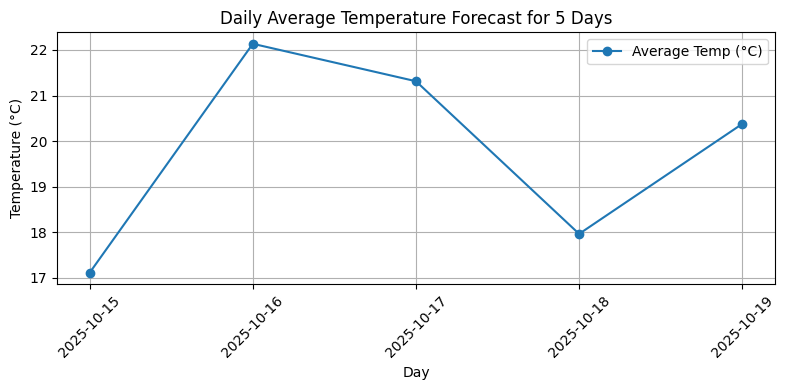

No daily forecast data available to plot precipitation.
Temps (normalized): [('2025-10-15', [16.04, 18.18])]


In [125]:
# Use your main fetcher; this expects you've already implemented get_weather_data(...)
wd = get_weather_data("Sydney", 5)
print("Error:", wd.get("error"))
create_temperature_visualisation(wd)
create_precipitation_visualisation(wd)

# Demonstrate get_temps on both shapes:
# 1) normalized weather_data
print("Temps (normalized):", list(get_temps(wd).items())[:1])

# 2) raw OpenWeather forecast JSON (only if you're using OpenWeather helpers)
# cur, fc, err = _openweather_fetch_raw("Perth")
# if not err and fc:
#     print("Temps (raw OpenWeather):", list(get_temps(fc).items())[:1])

## 🤖 Natural Language Processing

In [127]:
# Define parse_weather_question() and generate_weather_response() here
import re

_TIME_KEYWORDS = {
    "today": 0,
    "tomorrow": 1,
    "day after tomorrow": 2,
    "next day": 1,
    "this week": slice(0, 5),
    "next 3 days": slice(0, 3),
    "weekend": "weekend",  # special handling
}

_ATTR_KEYWORDS = {
    "temperature": ["temp", "temperature", "hot", "cold"],
    "precipitation": ["rain", "precip", "precipitation", "umbrella", "wet"],
    "wind": ["wind", "windy", "gust"],
    "humidity": ["humidity"], # Added humidity attribute
    "uv_index": ["uv", "uv index"], # Added uv_index attribute
    "weather_condition": ["conditions", "weather", "sunny", "cloudy", "rainy", "stormy"], # Added weather_condition attribute
}

_LOCATION_PATTERN = re.compile(r"in\s+([A-Za-z\-\s]+)$|for\s+([A-Za-z\-\s]+)$|at\s+([A-Za-z\-\s]+)$", re.IGNORECASE)


def parse_weather_question(question: str) -> Dict[str, Any]:
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted information including location, time period, and weather attribute
    """
    if not question or not isinstance(question, str):
        return {"error": "Invalid question provided."}

    q = question.strip().lower()

    # attribute detection
    attribute = None
    for attr, keys in _ATTR_KEYWORDS.items():
        if any(k in q for k in keys):
            attribute = attr
            break

    # time detection
    time_spec: Union[int, slice, str, None] = None
    for key, val in _TIME_KEYWORDS.items():
        if key in q:
            time_spec = val
            break

    # location detection: look for 'in X', 'for X', 'at X'
    location = None
    m = _LOCATION_PATTERN.search(q)
    if m:
        location = next((g for g in m.groups() if g), None)
        if location:
            location = location.strip().title()

    # Initialize variables to None if not found
    temperature = None  # Corrected typo and initialized
    uv_index = None
    weather_condition = None

    # Although the prompt didn't explicitly ask to extract these,
    # the original return statement in cell s3VaWXc0D_1W included them.
    # If the goal is to extract these, more sophisticated NLP would be needed.
    # For now, we'll just return the extracted location, attribute, and time.
    # If the user clarifies they want to extract temperature, uv, or condition,
    # we can add more complex parsing logic.

    return {
        "raw": question,
        "location": location,
        "attribute": attribute,
        "time": time_spec,
        # Returning None for these as the current parsing doesn't extract them
        "temperature": temperature, # Using the correctly spelled and initialized variable
        "uv_index": uv_index,
        "weather_condition": weather_condition
    }

In [ ]:
# @title
# Define parse_weather_question() and generate_weather_response() here
import re

def parse_weather_question(question):
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted information including location, time period, and weather attribute
    """
    q = question.lower()

    parsed = {
        "location": "Perth",
        "attribute": "temp",
        "time": "today"
    }

    if "tomorrow" in q:
        parsed["time"] = "tomorrow"

    if "rain" in q or "umbrella" in q or "precip" in q:
        parsed["attribute"] = "rain"
    elif "humidity" in q:
        parsed["attribute"] = "humidity"
    elif "temp" in q or "hot" in q or "cold" in q:
        parsed["attribute"] = "temp"

    for city in ["Perth", "Sydney", "Melbourne", "Brisbane", "Adelaide", "Darwin"]:
        if city in q:
            parsed["location"] = city.title()

    return parsed

def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    attr = parsed_question["attribute"]
    time = parsed_question["time"].title()
    city = weather_data.get("location", "Unknown")


    day_idx = 0 if parsed_question["time"] == "today" else 1
    forecast = weather_data.get("forecast", [])
    if not forecast:
        return f"⚠️ Sorry, no forecast available for {city}."


    if attr == "temp":
        return (
            f"{time} in {city}, the temperature will be around "
            f"{weather_data['current']['temp_C']}°C with "
            f"{weather_data['current']['description'].lower()}."
        )

    elif attr == "rain":
        chance = forecast[day_idx].get("hourly", [{}])[0].get("chanceofrain", "0")
        chance = int(chance)


        if chance > 50:
            umbrella = "You should take an umbrella."
        elif chance > 20:
            umbrella = "Maybe take an umbrella, just in case."
        else:
            umbrella = "No umbrella needed."

        return f"{time} in {city}, the chance of rain is {chance}%. {umbrella}"

    elif attr == "humidity":
        return f"{time} in {city}, the humidity is {weather_data['current']['humidity']}%."

    elif attr == "activity":
        temp = int(weather_data['current']['temp_C'])
        humidity = int(weather_data['current']['humidity'])
        desc = weather_data['current']['description'].lower()

        if temp > 35:
            return f"{time} in {city}, it's {temp}°C — too hot for outdoor activities."
        elif "rain" in desc or "storm" in desc:
            return f"{time} in {city}, conditions are {desc}. Not ideal for outdoor activities."
        elif humidity > 80:
            return f"{time} in {city}, it's {temp}°C but very humid ({humidity}%). Outdoor activities may feel uncomfortable."
        else:
            return f"{time} in {city}, with {temp}°C and {desc}, it's a good day for outdoor activities!"

    else:
        return f"⚠️ Sorry, I couldn't understand your question about {city}."

In [21]:
# @title
# Define parse_weather_question() and generate_weather_response() here

_TIME_KEYWORDS = {
    "today": 0,
    "tomorrow": 1,
    "day after tomorrow": 2,
    "next day": 1,
    "this week": slice(0, 5),
    "next 3 days": slice(0, 3),
    "weekend": "weekend",  # special handling
}

_ATTR_KEYWORDS = {
    "temperature": ["temp", "temperature", "hot", "cold"],
    "precipitation": ["rain", "precip", "precipitation", "umbrella", "wet"],
    "wind": ["wind", "windy", "gust"],
}

_LOCATION_PATTERN = re.compile(r"in\s+([A-Za-z\-\s]+)$|for\s+([A-Za-z\-\s]+)$|at\s+([A-Za-z\-\s]+)$", re.IGNORECASE)


def parse_weather_question(question: str) -> Dict[str, Any]:
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted information including location, time period, and weather attribute
    """
    if not question or not isinstance(question, str):
        return {"error": "Invalid question provided."}

    q = question.strip().lower()

    # attribute detection
    attribute = None
    for attr, keys in _ATTR_KEYWORDS.items():
        if any(k in q for k in keys):
            attribute = attr
            break

    # time detection
    time_spec: Union[int, slice, str, None] = None
    for key, val in _TIME_KEYWORDS.items():
        if key in q:
            time_spec = val
            break

    # location detection: look for 'in X', 'for X', 'at X'
    location = None
    m = _LOCATION_PATTERN.search(q)
    if m:
        location = next((g for g in m.groups() if g), None)
        if location:
            location = location.strip().title()

    return {
        "raw": question,
        "location": location,
        "attribute": attribute,
        "time": time_spec,
    }

In [55]:
# @title
def show_today_weather(weather_data):
    """
    Display today's weather summary for a given location.

    Args:
        weather_data (dict): Processed weather data from get_weather_data()
    """
    current = weather_data.get("current", {})
    forecast = weather_data.get("forecast", [])
    today = forecast[0] if forecast else {}
    location = weather_data.get("location", "Unknown")

    print("\n Today's Weather in {location}")
    print("---------------------------")
    print(f"Temperature now: {current.get('temp_C', 'N/A')}°C")
    print(f"Humidity: {current.get('humidity', 'N/A')}%")
    print(f"Conditions: {current.get('description', 'Unknown')}")

    if today:
        print(f"Max Temp: {today.get('maxtempC', 'N/A')}°C")
        print(f"Min Temp: {today.get('mintempC', 'N/A')}°C")

        # Check rain chance (max across all hours today)
        rain_chance = max(
            int(h.get("chanceofrain", 0)) for h in today.get("hourly", [])
        )
        print(f"Chance of Rain: {rain_chance}%")
    else:
        print("⚠️ No forecast data available.")

In [ ]:
# @title
cities = ["Sydney"]
questions = [
    "What is the temperature today?",
    "Should I take an umbrella tomorrow?",
    "What is the humidity today?",
    "Is it a good day for outdoor activities?",
    "What is the chance of rain today?"
]

for city in cities:
    print("\n===============================")
    print(f"🌏 Testing weather for {city}")
    print("===============================\n")

    sample = get_weather_data(city, forecast_days=3)

    for q in questions:
        parsed = parse_weather_question(q)  # Removed default_location=city
        parsed["location"] = city
        print("Q:", q)
        print("Parsed:", parsed)
        print("Answer:", generate_weather_response(parsed, sample))
        print("-----")


🌏 Testing weather for Sydney

Q: What is the temperature today?
Parsed: {'location': 'Sydney', 'attribute': 'temp', 'time': 'today'}
Answer: Today in Sydney, the temperature will be around 21°C with overcast.
-----
Q: Should I take an umbrella tomorrow?
Parsed: {'location': 'Sydney', 'attribute': 'rain', 'time': 'tomorrow'}
Answer: Tomorrow in Sydney, the chance of rain is 0%. No umbrella needed.
-----
Q: What is the humidity today?
Parsed: {'location': 'Sydney', 'attribute': 'humidity', 'time': 'today'}
Answer: Today in Sydney, the humidity is 33%.
-----
Q: Is it a good day for outdoor activities?
Parsed: {'location': 'Sydney', 'attribute': 'temp', 'time': 'today'}
Answer: Today in Sydney, the temperature will be around 21°C with overcast.
-----
Q: What is the chance of rain today?
Parsed: {'location': 'Sydney', 'attribute': 'rain', 'time': 'today'}
Answer: Today in Sydney, the chance of rain is 0%. No umbrella needed.
-----


## 🧭 User Interface

In [103]:
# Define menu functions using pyinputplus or ipywidgets here
import json
def get_temps(data):
        daily_temps = {}

        for item in data["list"]:
                dt_txt = item["dt_txt"] # e.g., '2025-10-16 03:00:00'
                date_str = dt_txt.split(" ")[0] # Just the date part
                temp = item["main"]["temp"]

                if date_str not in daily_temps:
                        daily_temps[date_str] = []

                daily_temps[date_str].append(temp)

        return daily_temps

def run_application():
        """Simple console menu using pyinputplus if available, else fallback to input()."""
        global _LAST_LOCATION, _LAST_FORECAST_DAYS, _LAST_WEATHER

        def ask(prompt: str, choices: Optional[List[str]] = None) -> str:
                if pyip and choices:
                        return pyip.inputMenu(choices, prompt=prompt + "\n", numbered=True)
                elif pyip:
                        return pyip.inputStr(prompt)
                else:
                        # basic fallback
                        return input(prompt + (f" ({'/'.join(choices)})" if choices else "") + ": ")

        print("Hello! Welcome to WeatherWise, I'm ready to predict the temperature for you.")
        while True:
            while True:
                loc = ask("Enter the location (e.g., Perth)")
                if not loc.isdigit(): # Check if the input is not just digits
                    break
                else:
                    print(f"'{loc}' is not a valid location. Please enter a city or location name.")

            days = 5 # Fetch 5 days of data for potential future use
            data = get_weather_data(loc, forecast_days=days)

            _LAST_LOCATION, _LAST_FORECAST_DAYS, _LAST_WEATHER = loc, days, data

            if data and data.get("message") == "city not found":
                print(f"Error fetching weather data: {data['message']}. Please try another location.")
                # Continue the outer loop to ask for location again
            elif data and data.get("message"):
                print(f"Error fetching initial weather data: {data['message']}")
                break # Exit the loop for other errors
            elif not data:
                 print("Could not retrieve initial weather data for the specified location.")
                 # Optionally, break or continue based on desired behavior for other errors
                 break
            else:
                # Data fetched successfully, break the outer loop
                break


        while True:
                choices = [
                        "Fetch weather forecast",
                        "Show temperature chart",
                        # "Show precipitation chart",
                        "Show weather summary",
                        "Ask any question",
                        "Quit",
                ]
                choice = ask("Choose an option", choices)

                if choice == choices[0]:
                        if not _LAST_WEATHER:
                             loc = ask("Enter location (e.g., Perth)")
                             days = 5 # Fetch 5 days of data for potential future use
                             data = get_weather_data(loc, forecast_days=days)

                             _LAST_LOCATION, _LAST_FORECAST_DAYS, _LAST_WEATHER = loc, days, data

                             if data and data.get("message"):
                                 print(f"Error fetching weather data: {data['message']}")
                                 continue
                             elif not data:
                                 print("Could not retrieve weather data for the specified location.")
                                 continue


                        if _LAST_WEATHER and _LAST_WEATHER.get("list"):
                            daily_temps = get_temps(_LAST_WEATHER)
                            # Iterate through the first day's temperatures only
                            first_day_date = list(daily_temps.keys())[0]
                            temps = daily_temps[first_day_date]
                            average_temp = sum(temps) / len(temps) if temps else 0
                            print(f"\nAverage temperatures for {_LAST_LOCATION} Today ({first_day_date}) : {average_temp:.2f}°C")

                            # Add conditional messages based on average temperature
                            if 28 <= average_temp <= 32:
                                print("It is quite hot today. Please wear cool clothing and use sunscreen.")
                            elif 22 <= average_temp <= 27:
                                print("Today has good weather.")
                            elif 17 <= average_temp <= 21:
                                print("It is quite cold today. Please wear warm clothes if you go out.")
                            elif average_temp < 17:
                                print("It is freezing! Stay home and turn on the heater.")
                            elif average_temp > 32: # Corrected condition for "burning"
                                print("It is burning hot! Stay home and turn on the air conditioning.")
                        elif _LAST_WEATHER and _LAST_WEATHER.get("message"):
                             print(f"Error fetching weather data: {_LAST_WEATHER['message']}")
                        else:
                             print("Could not retrieve weather data for the specified location.")


                elif choice == choices[1]:
                        # Ask for the number of days for the chart
                        num_days_chart = pyip.inputInt("Enter the number of days for the temperature chart (up to 5): ", min=1, max=5)
                        create_temperature_visualisation(_LAST_WEATHER, num_days=num_days_chart, output_type='display')

                elif choice == choices[2]:
                        if not _LAST_WEATHER:
                                print("Please fetch weather first.")
                                continue
                        # TODO: implement weather summary function
                        create_weather_summary(_LAST_WEATHER)

                elif choice == choices[3]:
                        q = ask("Ask a weather question (e.g., 'Will it rain tomorrow in Perth?')")
                        parsed = parse_weather_question(q)
                        # TODO : Edit function content
                        resp = generate_weather_response(parsed, _LAST_WEATHER)
                        print(resp)

                elif choice == choices[4]:
                        print("Goodbye have a great day!")
                        break

In [ ]:
# @title
# Define menu functions using pyinputplus or ipywidgets here
import pyinputplus as pyip

def run_app():
    """
    WeatherWise main menu using pyinputplus (supports any city).
    """
    while True:

        city = input("\n🌏 Enter a city name (or type 'exit' to quit): ").strip()
        if city.lower() == "exit":
            print("\n👋 Goodbye! Have a Great Day 🌤️")
            break

        while True:
            choice = pyip.inputMenu(
                [
                    "Today’s Weather",
                    "Current Weather",
                    "Forecast Charts",
                    "Ask a Question",
                    "Outdoor Activities Advice",
                    "Change City",
                    "Exit"
                ],
                numbered=True
            )

            if choice == "Today’s Weather":
                data = get_weather_data(city, forecast_days=1)
                show_today_weather(data)

            elif choice == "Current Weather":
                data = get_weather_data(city, forecast_days=3)
                print(f"\n Current Weather in {city}:")
                print(f"Temperature: {data['current']['temp_C']}°C")
                print(f"Humidity: {data['current']['humidity']}%")
                print(f"Conditions: {data['current']['description']}")

            elif choice == "Forecast Charts":
                data = get_weather_data(city, forecast_days=3)
                print(f"\n Generating charts for {city}...")
                create_temperature_visualisation(data)
                create_precipitation_visualisation(data)

            elif choice == "Ask a Question":
                data = get_weather_data(city, forecast_days=3)
                q = input(f"\n Ask your weather question about {city}: ")
                parsed = parse_weather_question(q)
                parsed["location"] = city
                print( generate_weather_response(parsed, data))

            elif choice == "Outdoor Activities Advice":
                data = get_weather_data(city, forecast_days=1)
                parsed = {"location": city, "attribute": "activity", "time": "today"}
                print( generate_weather_response(parsed, data))

            elif choice == "Change City":
                break

            elif choice == "Exit":
                print("\n👋 Goodbye! Have a Great Day 🌤️")
                return

In [68]:
# @title
# Define menu functions using pyinputplus or ipywidgets here

def run_console_menu():
    """Simple console menu using pyinputplus if available, else fallback to input()."""
    global _LAST_LOCATION, _LAST_FORECAST_DAYS, _LAST_WEATHER

    def ask(prompt: str, choices: Optional[List[str]] = None) -> str:
        if pyip and choices:
            return pyip.inputMenu(choices, prompt=prompt + "\n", numbered=True)
        elif pyip:
            return pyip.inputStr(prompt)
        else:
            # basic fallback
            return input(prompt + (f" ({'/'.join(choices)})" if choices else "") + ": ")

    # Start with asking for a location
    current_location = ask("Enter a city name")

    while True:
        choice = ask(prompt=f"Choose an option for {current_location}", choices=[
                    "Today’s Weather",
                    "Current Weather",
                    "Forecast Charts",
                    "Ask a Question",
                    "Outdoor Activities Advice",
                    "Change City",
                    "Exit"
        ])

        if choice == "Today’s Weather":
            data = get_weather_data(current_location, forecast_days=1)
            # Check if data is a dictionary and has an error key
            if isinstance(data, dict) and data.get("error"):
                print("Error:", data["error"])
            elif isinstance(data, dict): # Check if it's a dictionary before accessing keys
                show_today_weather(data) # Assuming show_today_weather exists
            else:
                 print("⚠️ Could not retrieve weather data for today.")


        elif choice == "Current Weather":
            data = get_weather_data(current_location, forecast_days=1) # Current weather is usually part of day 1 data
            # Check if data is a dictionary and has an error key
            if isinstance(data, dict) and data.get("error"):
                print("Error:", data["error"])
            elif isinstance(data, dict) and data.get("current"): # Check if it's a dictionary and has 'current' key
                print(f"\n🌡️ Current Weather in {current_location}:")
                print(f"Temperature: {data['current'].get('temp_C', 'N/A')}°C")
                print(f"Humidity: {data['current'].get('humidity', 'N/A')}%")
                print(f"Conditions: {data['current'].get('description', 'Unknown')}")
            else:
                 print(f"⚠️ Current weather data not available for {current_location}.")


        elif choice == "Forecast Charts":
            days_str = ask("Forecast days (1-5)", choices=[str(i) for i in range(1, 6)]) or '5'
            try:
                days = max(1, min(int(days_str), 5))
            except Exception:
                days = 5
            data = get_weather_data(current_location, forecast_days=days)
            # Check if data is a dictionary and has an error key
            if isinstance(data, dict) and data.get("error"):
                print("Error:", data["error"])
            elif isinstance(data, dict): # Check if it's a dictionary before passing to visualization
                print(f"\n📊 Generating charts for {current_location}...")
                create_temperature_visualisation(data) # Assuming these functions exist
                create_precipitation_visualisation(data) # Assuming these functions exist
            else:
                 print("⚠️ Could not retrieve forecast data for charts.")


        elif choice == "Ask a Question":
            q = ask(f"Ask your weather question about {current_location}: ")
            data = get_weather_data(current_location, forecast_days=5) # Fetch enough data for questions
            # Check if data is a dictionary and has an error key
            if isinstance(data, dict) and data.get("error"):
                 print("Error:", data["error"])
            elif isinstance(data, dict): # Check if it's a dictionary before passing to NLP
                parsed = parse_weather_question(q) # Assuming parse_weather_question exists
                parsed["location"] = current_location # Ensure correct location
                print("Answer:", generate_weather_response(parsed, data)) # Assuming generate_weather_response exists
            else:
                 print("⚠️ Could not retrieve weather data to answer your question.")


        elif choice == "Outdoor Activities Advice":
            data = get_weather_data(current_location, forecast_days=1) # Need today's conditions
            # Check if data is a dictionary and has an error key
            if isinstance(data, dict) and data.get("error"):
                 print("Error:", data["error"])
            elif isinstance(data, dict): # Check if it's a dictionary before passing to NLP
                parsed = {"location": current_location, "attribute": "activity", "time": "today"}
                print( generate_weather_response(parsed, data))
            else:
                 print("⚠️ Could not retrieve weather data for activity advice.")


        elif choice == "Change City":
            current_location = ask("Enter a new city name")
            _LAST_LOCATION = current_location # Update global state if needed


        elif choice == "Exit":
            print("\n👋 Goodbye! Have a Great Day 🌤️")
            return

## 🧩 Main Application Logic

In [101]:
# Tie everything together here

def generate_weather_response(parsed_question: Dict[str, Any], weather_data: Dict[str, Any]) -> str:
	"""
	Generate a natural language response to a weather question.

	Args:
		parsed_question (dict): Parsed question data
		weather_data (dict): Weather data

	Returns:
		str: Natural language response
	"""
	if parsed_question.get("error"):
		return parsed_question["error"]
	if weather_data.get("error"):
		return weather_data["error"]

	location = weather_data.get("location") or parsed_question.get("location") or "the selected location"
	current = weather_data.get("current", {})
	daily = weather_data.get("daily", [])

	attribute = parsed_question.get("attribute")
	time_spec = parsed_question.get("time")

	def format_day(d: Dict[str, Any]) -> str:
		date = d.get("date", "")
		desc = (d.get("hourly", [{}])[0].get("weatherDesc") or [{"value": ""}])[0].get("value", "")
		return f"{date} ({desc})"

	if attribute == "temperature":
		# If today requested or unspecified, use current
		if time_spec in (None, 0):
			t = current.get("temp_C")
			feels = current.get("FeelsLikeC") or current.get("FeelsLikeC")
			desc = (current.get("weatherDesc") or [{"value": ""}])[0].get("value", "")
			if t is not None:
				return f"Right now in {location}: {t}°C, {desc}. Feels like {feels}°C."
		# Otherwise use daily forecast
		if isinstance(time_spec, int) and 0 <= time_spec < len(daily):
			d = daily[time_spec]
			return (
				f"In {location} on {d.get('date')}: min {d.get('mintempC')}°C, max {d.get('maxtempC')}°C."
			)
		if isinstance(time_spec, slice):
			parts = []
			for d in daily[time_spec]:
				parts.append(f"{d.get('date')}: {d.get('mintempC')}–{d.get('maxtempC')}°C")
			if parts:
				return f"Temperature forecast for {location}: " + "; ".join(parts)

	if attribute == "precipitation":
		if isinstance(time_spec, int) and 0 <= time_spec < len(daily):
			d = daily[time_spec]
			mm = d.get("totalPrecipMM")
			return f"Expected precipitation in {location} on {d.get('date')}: {mm} mm."
		if time_spec in (None, 0):
			# Try current precipitation
			precip_mm = current.get("precipMM")
			if precip_mm is not None:
				return f"Right now in {location}, precipitation is {precip_mm} mm."
		if isinstance(time_spec, slice):
			parts = []
			for d in daily[time_spec]:
				parts.append(f"{d.get('date')}: {d.get('totalPrecipMM', 0)} mm")
			if parts:
				return f"Precipitation forecast for {location}: " + "; ".join(parts)

	if attribute == "wind":
		if time_spec in (None, 0):
			spd = current.get("windspeedKmph")
			dirp = current.get("winddir16Point")
			if spd is not None:
				return f"Current wind in {location}: {spd} km/h {dirp or ''}."

	# Fallback generic summary
	if current:
		desc = (current.get("weatherDesc") or [{"value": ""}])[0].get("value", "")
		t = current.get("temp_C")
		return f"Currently in {location}: {t}°C, {desc}."

	return "I'm unable to summarise the weather from the provided data."

In [45]:
# @title
# Tie everything together here

def generate_weather_response(parsed_question: Dict[str, Any], weather_data: Dict[str, Any]) -> str:
	"""
	Generate a natural language response to a weather question.

	Args:
		parsed_question (dict): Parsed question data
		weather_data (dict): Weather data

	Returns:
		str: Natural language response
	"""
	if parsed_question.get("error"):
		return parsed_question["error"]
	if weather_data.get("error"):
		return weather_data["error"]

	location = weather_data.get("location") or parsed_question.get("location") or "the selected location"
	current = weather_data.get("current", {})
	daily = weather_data.get("daily", [])

	attribute = parsed_question.get("attribute")
	time_spec = parsed_question.get("time")

	def format_day(d: Dict[str, Any]) -> str:
		date = d.get("date", "")
		desc = (d.get("hourly", [{}])[0].get("weatherDesc") or [{"value": ""}])[0].get("value", "")
		return f"{date} ({desc})"

	if attribute == "temperature":
		# If today requested or unspecified, use current
		if time_spec in (None, 0):
			t = current.get("temp_C")
			feels = current.get("FeelsLikeC") or current.get("FeelsLikeC")
			desc = (current.get("weatherDesc") or [{"value": ""}])[0].get("value", "")
			if t is not None:
				return f"Right now in {location}: {t}°C, {desc}. Feels like {feels}°C."
		# Otherwise use daily forecast
		if isinstance(time_spec, int) and 0 <= time_spec < len(daily):
			d = daily[time_spec]
			return (
				f"In {location} on {d.get('date')}: min {d.get('mintempC')}°C, max {d.get('maxtempC')}°C."
			)
		if isinstance(time_spec, slice):
			parts = []
			for d in daily[time_spec]:
				parts.append(f"{d.get('date')}: {d.get('mintempC')}–{d.get('maxtempC')}°C")
			if parts:
				return f"Temperature forecast for {location}: " + "; ".join(parts)

	if attribute == "precipitation":
		if isinstance(time_spec, int) and 0 <= time_spec < len(daily):
			d = daily[time_spec]
			mm = d.get("totalPrecipMM")
			return f"Expected precipitation in {location} on {d.get('date')}: {mm} mm."
		if time_spec in (None, 0):
			# Try current precipitation
			precip_mm = current.get("precipMM")
			if precip_mm is not None:
				return f"Right now in {location}, precipitation is {precip_mm} mm."
		if isinstance(time_spec, slice):
			parts = []
			for d in daily[time_spec]:
				parts.append(f"{d.get('date')}: {d.get('totalPrecipMM', 0)} mm")
			if parts:
				return f"Precipitation forecast for {location}: " + "; ".join(parts)

	if attribute == "wind":
		if time_spec in (None, 0):
			spd = current.get("windspeedKmph")
			dirp = current.get("winddir16Point")
			if spd is not None:
				return f"Current wind in {location}: {spd} km/h {dirp or ''}."

	# Fallback generic summary
	if current:
		desc = (current.get("weatherDesc") or [{"value": ""}])[0].get("value", "")
		t = current.get("temp_C")
		return f"Currently in {location}: {t}°C, {desc}."

	return "I'm unable to summarise the weather from the provided data."

In [33]:
# @title
# Tie everything together here
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """

    attr = parsed_question["attribute"]
    time = parsed_question["time"].title()
    city = parsed_question["location"]

    # Today = 0, Tomorrow = 1 (fallback if forecast not enough days)
    day_idx = 0 if parsed_question["time"] == "today" else 1
    forecast = weather_data.get("forecast", [])

    if not forecast:
        return f"⚠️ Sorry, no forecast available for {city}."

    # 🌡️ Temperature
    if attr == "temp":
        return (
            f"{time} in {city}, the temperature will be around "
            f"{weather_data['current']['temp_C']}°C with "
            f"{weather_data['current']['description'].lower()}."
        )

    # 🌧️ Rain / Umbrella advice
    elif attr == "rain":
        chance = int(forecast[min(day_idx, len(forecast)-1)].get("hourly", [{}])[0].get("chanceofrain", "0"))
        if chance > 50:
            umbrella = "You should take an umbrella."
        elif chance > 20:
            umbrella = "Maybe take an umbrella, just in case."
        else:
            umbrella = "No umbrella needed."
        return f"{time} in {city}, the chance of rain is {chance}%. {umbrella}"

    # 💧 Humidity
    elif attr == "humidity":
        return f"{time} in {city}, the humidity is {weather_data['current']['humidity']}%."

    # 🏃 Outdoor Activities
    elif attr == "activity":
        temp = int(weather_data['current']['temp_C'])
        humidity = int(weather_data['current']['humidity'])
        desc = weather_data['current']['description'].lower()

        if temp > 35:
            return f"{time} in {city}, it's {temp}°C — too hot for outdoor activities."
        elif "rain" in desc or "storm" in desc:
            return f"{time} in {city}, conditions are {desc}. Not ideal for outdoor activities."
        elif humidity > 80:
            return f"{time} in {city}, it's {temp}°C but very humid ({humidity}%). Outdoor activities may feel uncomfortable."
        else:
            return f"{time} in {city}, with {temp}°C and {desc}, it's a good day for outdoor activities!"

    # ⚠️ Fallback if not understood
    else:
        return f"⚠️ Sorry, I couldn't understand your question about {city}."

In [31]:
# @title
# Tie everything together here

def generate_weather_response(parsed_question: Dict[str, Any], weather_data: Dict[str, Any]) -> str:
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    if parsed_question.get("error"):
        return parsed_question["error"]
    if weather_data.get("error"):
        return weather_data["error"]

    location = weather_data.get("location") or parsed_question.get("location") or "the selected location"
    current = weather_data.get("current", {})
    daily = weather_data.get("daily", [])

    attribute = parsed_question.get("attribute")
    time_spec = parsed_question.get("time")

    def format_day(d: Dict[str, Any]) -> str:
        date = d.get("date", "")
        desc = (d.get("hourly", [{}])[0].get("weatherDesc") or [{"value": ""}])[0].get("value", "")
        return f"{date} ({desc})"

    if attribute == "temperature":
        # If today requested or unspecified, use current
        if time_spec in (None, 0):
            t = current.get("temp_C")
            feels = current.get("FeelsLikeC") or current.get("FeelsLikeC")
            desc = (current.get("weatherDesc") or [{"value": ""}])[0].get("value", "")
            if t is not None:
                return f"Right now in {location}: {t}°C, {desc}. Feels like {feels}°C."
        # Otherwise use daily forecast
        if isinstance(time_spec, int) and 0 <= time_spec < len(daily):
            d = daily[time_spec]
            return (
                f"In {location} on {d.get('date')}: min {d.get('mintempC')}°C, max {d.get('maxtempC')}°C."
            )
        if isinstance(time_spec, slice):
            parts = []
            for d in daily[time_spec]:
                parts.append(f"{d.get('date')}: {d.get('mintempC')}–{d.get('maxtempC')}°C")
            if parts:
                return f"Temperature forecast for {location}: " + "; ".join(parts)

    if attribute == "precipitation":
        if isinstance(time_spec, int) and 0 <= time_spec < len(daily):
            d = daily[time_spec]
            mm = d.get("totalPrecipMM")
            return f"Expected precipitation in {location} on {d.get('date')}: {mm} mm."
        if time_spec in (None, 0):
            # Try current precipitation
            precip_mm = current.get("precipMM")
            if precip_mm is not None:
                return f"Right now in {location}, precipitation is {precip_mm} mm."
        if isinstance(time_spec, slice):
            parts = []
            for d in daily[time_spec]:
                parts.append(f"{d.get('date')}: {d.get('totalPrecipMM', 0)} mm")
            if parts:
                return f"Precipitation forecast for {location}: " + "; ".join(parts)

    if attribute == "wind":
        if time_spec in (None, 0):
            spd = current.get("windspeedKmph")
            dirp = current.get("winddir16Point")
            if spd is not None:
                return f"Current wind in {location}: {spd} km/h {dirp or ''}."

    # Fallback generic summary
    if current:
        desc = (current.get("weatherDesc") or [{"value": ""}])[0].get("value", "")
        t = current.get("temp_C")
        return f"Currently in {location}: {t}°C, {desc}."

    return "I'm unable to summarise the weather from the provided data."

## 🧪 Testing and Examples

In [128]:
# Define menu functions using pyinputplus or ipywidgets here
import json
def get_temps(data):
        daily_temps = {}

        for item in data["list"]:
                dt_txt = item["dt_txt"] # e.g., '2025-10-16 03:00:00'
                date_str = dt_txt.split(" ")[0] # Just the date part
                temp = item["main"]["temp"]

                if date_str not in daily_temps:
                        daily_temps[date_str] = []

                daily_temps[date_str].append(temp)

        return daily_temps

def run_application():
        """Simple console menu using pyinputplus if available, else fallback to input()."""
        global _LAST_LOCATION, _LAST_FORECAST_DAYS, _LAST_WEATHER

        def ask(prompt: str, choices: Optional[List[str]] = None) -> str:
                if pyip and choices:
                        return pyip.inputMenu(choices, prompt=prompt + "\n", numbered=True)
                elif pyip:
                        return pyip.inputStr(prompt)
                else:
                        # basic fallback
                        return input(prompt + (f" ({'/'.join(choices)})" if choices else "") + ": ")

        print("Hello! Welcome to WeatherWise, I'm ready to predict the temperature for you.")
        while True:
            while True:
                loc = ask("Enter the location (e.g., Perth)")
                if not loc.isdigit(): # Check if the input is not just digits
                    break
                else:
                    print(f"'{loc}' is not a valid location. Please enter a city or location name.")

            days = 5 # Fetch 5 days of data for potential future use
            data = get_weather_data(loc, forecast_days=days)

            _LAST_LOCATION, _LAST_FORECAST_DAYS, _LAST_WEATHER = loc, days, data

            if data and data.get("message") == "city not found":
                print(f"Error fetching weather data: {data['message']}. Please try another location.")
                # Continue the outer loop to ask for location again
            elif data and data.get("message"):
                print(f"Error fetching initial weather data: {data['message']}")
                break # Exit the loop for other errors
            elif not data:
                 print("Could not retrieve initial weather data for the specified location.")
                 # Optionally, break or continue based on desired behavior for other errors
                 break
            else:
                # Data fetched successfully, break the outer loop
                break


        while True:
                choices = [
                        "Fetch weather forecast",
                        "Show temperature chart",
                        # "Show precipitation chart",
                        "Show weather summary",
                        "Ask any question",
                        "Quit",
                ]
                choice = ask("Choose an option", choices)

                if choice == choices[0]:
                        if not _LAST_WEATHER:
                             loc = ask("Enter location (e.g., Perth)")
                             days = 5 # Fetch 5 days of data for potential future use
                             data = get_weather_data(loc, forecast_days=days)

                             _LAST_LOCATION, _LAST_FORECAST_DAYS, _LAST_WEATHER = loc, days, data

                             if data and data.get("message"):
                                 print(f"Error fetching weather data: {data['message']}")
                                 continue
                             elif not data:
                                 print("Could not retrieve weather data for the specified location.")
                                 continue


                        if _LAST_WEATHER and _LAST_WEATHER.get("list"):
                            daily_temps = get_temps(_LAST_WEATHER)
                            # Iterate through the first day's temperatures only
                            first_day_date = list(daily_temps.keys())[0]
                            temps = daily_temps[first_day_date]
                            average_temp = sum(temps) / len(temps) if temps else 0
                            print(f"\nAverage temperatures for {_LAST_LOCATION} Today ({first_day_date}) : {average_temp:.2f}°C")

                            # Add conditional messages based on average temperature
                            if 28 <= average_temp <= 32:
                                print("It is quite hot today. Please wear cool clothing and use sunscreen.")
                            elif 22 <= average_temp <= 27:
                                print("Today has good weather.")
                            elif 17 <= average_temp <= 21:
                                print("It is quite cold today. Please wear warm clothes if you go out.")
                            elif average_temp < 17:
                                print("It is freezing! Stay home and turn on the heater.")
                            elif average_temp > 32: # Corrected condition for "burning"
                                print("It is burning hot! Stay home and turn on the air conditioning.")
                        elif _LAST_WEATHER and _LAST_WEATHER.get("message"):
                             print(f"Error fetching weather data: {_LAST_WEATHER['message']}")
                        else:
                             print("Could not retrieve weather data for the specified location.")


                elif choice == choices[1]:
                        # The original code here asked for num_days, but create_temperature_visualisation doesn't take it.
                        # Assuming the user wants a 5-day chart as fetched initially.
                        create_temperature_visualisation(_LAST_WEATHER, output_type='display')

                elif choice == choices[2]:
                        if not _LAST_WEATHER:
                                print("Please fetch weather first.")
                                continue
                        # TODO: implement weather summary function
                        create_weather_summary(_LAST_WEATHER)

                elif choice == choices[3]:
                        q = ask("Ask a weather question (e.g., 'Will it rain tomorrow in Perth?')")
                        parsed = parse_weather_question(q)
                        # TODO : Edit function content
                        resp = generate_weather_response(parsed, _LAST_WEATHER)
                        print(resp)

                elif choice == choices[4]:
                        print("Goodbye have a great day!")
                        break

In [129]:
run_application()

Hello! Welcome to WeatherWise, I'm ready to predict the temperature for you.
Enter the location (e.g., Perth)Perth
Choose an option
1. Fetch weather forecast
2. Show temperature chart
3. Show weather summary
4. Ask any question
5. Quit
1

Average temperatures for Perth Today (2025-10-15) : 15.13°C
It is freezing! Stay home and turn on the heater.
Choose an option
1. Fetch weather forecast
2. Show temperature chart
3. Show weather summary
4. Ask any question
5. Quit
5
Goodbye have a great day!


## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.